In [53]:
# from leecarter import leecarter
import pandas as pd
from tqdm import tqdm
import numpy.matlib
import numpy as np
from matplotlib import pyplot as plt

#from statsmodels.tsa.arima.model import ARIMA

#import warnings
#from statsmodels.tools.sm_exceptions import ConvergenceWarning
#warnings.simplefilter('ignore', ConvergenceWarning)
#warnings.simplefilter('ignore', UserWarning)

In [54]:
Image_width = 10
plt.rc('text', usetex = True) # latex ticks
plt.rc('text.latex')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern'],
})

EXTRA_SMALL = 10
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [55]:
filename = 'death_rates2.txt'

mortality = pd.read_csv(filename, delim_whitespace=True)
mortality = mortality[mortality['Age'] != '110+']
mortality['Age'] = mortality['Age'].astype(int)
mortality['Year'] = mortality['Year'].astype(int)
mortality = mortality[mortality['Age'] <= 100]
mortality['Female_l'] = np.log(mortality['Female'].astype(float))
mortality['Male_l'] = np.log(mortality['Male'].astype(float))
mortality['Total_l'] = np.log(mortality['Total'].astype(float))
mortality = mortality[['Year', 'Age', 'Female_l', 'Male_l', 'Total_l']]
mortality

,Year,Age,Female_l,Male_l,Total_l
0,1958,0,-2.723920,-2.480397,-2.591788
1,1958,1,-5.352562,-5.291540,-5.320972
2,1958,2,-6.357324,-6.197751,-6.272237
3,1958,3,-6.732962,-6.527266,-6.622576
4,1958,4,-7.066751,-6.837297,-6.943382
...,...,...,...,...,...
6867,2019,96,-1.240243,-1.143835,-1.220129
6868,2019,97,-1.123130,-1.046502,-1.108135
6869,2019,98,-1.127061,-0.963167,-1.093425
6870,2019,99,-0.980088,-0.864780,-0.957410


In [56]:
column = 'Female_l'

# **Linear regression**

In [57]:
fm = mortality.pivot(index="Age", columns="Year", values=column)
data = fm.values # (101 (age), 62 (years))

total_years = data.shape[1]
trained_from = 30
trained_to = 41
trained_data = data[:,trained_from:trained_to+1]
trained_time = np.arange(trained_from, trained_to + 1)


b1 = ((trained_time[None,:] - trained_time.mean())*(trained_data-trained_data.mean(1)[:,None])).sum(1)/((trained_time - trained_time.mean())**2).sum()
b0 = trained_data.mean(1)-b1*trained_time.mean()

b1 = b1[:, None] 
b0 = b0[:, None]


estimated_time = np.arange(trained_to + 1, total_years + 1)
estimated_data_without_rw = np.exp(b1*estimated_time[None,:] + b0)

adjusted_trend = b1*trained_time[None,:] + b0

# Lee - Carter

In [58]:
def fit_arima(matrix):
    d = []
    for a in range(5):
        for b in range(5):
            for c in range(5):
                mod = ARIMA(matrix, order=(a,b,c))
                res = mod.fit()
                d.append([res.llf, a, b, c])

    return max(d)



def predict_no_arima(matrix, column: str='Female_l', age=65, steps=21, training_start = 30):
    fm = matrix.pivot(index="Age", columns="Year", values=column)
    fm_train = fm.iloc[:,training_start:round(np.shape(fm)[1]*2/3)]
    fm = fm_train
    fm = fm.to_numpy()
    a_x = fm.mean(axis=1)
    T = np.shape(fm)[1]
    z_xt = fm - np.matlib.repmat(a_x, T, 1).T
    U, S, V = np.linalg.svd(z_xt, full_matrices=True)
    b_x = U[:, 0]/U[:, 0].sum()
    k_t = V[0, :]*S[0]*U[:, 0].sum()
    a_x = a_x + k_t.sum()*b_x
    k_t = k_t - k_t.sum()

    theta = (k_t[-1] - k_t[0]) / (len(k_t) - 1) # according to the Girosi, King, 2007 and Lee Carter done it the same way. ARIMA was exploding

    pred = k_t[-1] + theta * np.arange(1, steps + 1)

    return np.exp(a_x[age] + b_x[age]*pred)

estimated_data_lee_carter = []
for age in range(0, 101):
    W_lengths = [6, 7, 8, 9, 10, 41]
    Vals = np.ones((len(W_lengths), 21))
    for i, w_len in enumerate(W_lengths):
        Vals[i, :] = predict_no_arima(mortality, column, age, training_start = 41 - w_len)
    vals = np.mean(Vals, 0)
    estimated_data_lee_carter.append(vals)

estimated_data_lee_carter = np.array(estimated_data_lee_carter)    
print(estimated_data_lee_carter.shape)

(101, 21)


# Products

## Term insurance

Let's consider n-year term life insurance. Forecasted present value net single premium is then:

$$ A^{1, f}_{x:n} = \sum_{k=0}^{n-1} v^{k+1}  {}_k  p^0_x  q^k_{x+k},$$

where $q^t_{x+k}$ is forecasted probability in t-th year of dying in one year of person aged $x+k$. Also see that:

$$ {}_k  p^0_x =  p^0_x p^1_{x+1} \cdot ... \cdot p^{k-1}_{x+(k-1)}, $$

where $p^k_x = 1- q^k_x$.

In [59]:
def calculateProbabilities(estimated_data, n):

    Qx = estimated_data # shape (x, year)




    a = np.arange(0, Qx.shape[1])
    b = np.arange(0, Qx.shape[0])
    a = a[None, :]
    b = b[:, None]


    kPx = []
    Qkx = []
    for x in range(0, Qx.shape[0]-n-1):
        Px = []

        indexes = (b - x == a)*(a < n)

        Qkx.append(Qx[indexes].tolist())
        for k in range(0, n-1):
            indexes = (b - x == a)*(a <= k) # bierzemy ukośnie
            p = (1-Qx)[indexes].prod()
            Px.append(p)
        kPx.append(Px)

    kPx = np.array(kPx) # shape (x, k)
    kPx = np.hstack((np.ones((kPx.shape[0],1)), kPx))
    Qkx = np.array(Qkx) # shape (starting x, k)



    #forecasting_horizon = np.arange(0, n)
    #forecasting_horizon = forecasting_horizon[None, :]

    #discounting_factor = v**forecasting_horizon

    return kPx, Qkx #, discounting_factor


(80,)


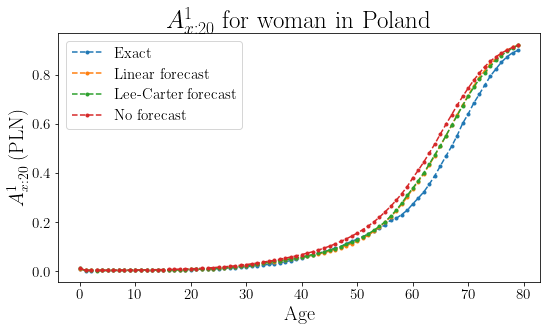

In [60]:
n = 20
delta = 0.01

v = np.exp(-delta)
forecasting_horizon = np.arange(1, n+1)
forecasting_horizon = forecasting_horizon[None, :]

discounting_factor = v**forecasting_horizon


Qx = estimated_data_without_rw # shape (x, year)

kPx, Qkx = calculateProbabilities(Qx, n)

A_linear = discounting_factor*kPx*Qkx
if np.any(kPx > 1): print("error")
if np.any(Qkx > 1): print("error")
A_linear = A_linear.sum(1)

linear = (kPx, Qkx)




Qx = estimated_data_lee_carter # shape (x, year)
if np.any(Qx > 1): print("Jakim cudem (lee-carter)", Qx)
    
kPx, Qkx = calculateProbabilities(Qx, n)

A_LC = discounting_factor*kPx*Qkx
if np.any(kPx > 1): print("error")
if np.any(Qkx > 1): print("error")
A_LC = A_LC.sum(1)

LC = (kPx, Qkx)


# real data
Qx = np.exp(data[:, 42:]) # shape (x, year)

kPx, Qkx = calculateProbabilities(Qx, n)

A_farseer = discounting_factor*kPx*Qkx
if np.any(kPx > 1): print("error")
if np.any(Qkx > 1): print("error")
A_farseer = A_farseer.sum(1)

farseer = (kPx, Qkx)

# without forecasting 
Q = np.exp(data[:, 41])


kPx = []
Qkx = []
for x in range(0, Qx.shape[0]-n-1):
    kPx.append((1-Q[x:x+n-1]).cumprod())
    Qkx.append(Q[x:x+n])
kPx = np.array(kPx)
kPx = np.hstack((np.ones((kPx.shape[0],1)), kPx))
Qkx = np.array(Qkx)
#print(kPx.shape) # (x, k)
#print(discounting_factor.shape)
#print(Qkx.shape)

no_prediction = (kPx, Qkx)

straight_forward_A = (discounting_factor*Qkx*kPx).sum(1)
print(straight_forward_A.shape)

fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.5 * Image_width))
ax.plot(A_farseer, '.--', label="Exact")
ax.plot(A_linear, '.--', label="Linear forecast")
ax.plot(A_LC, '.--', label = "Lee-Carter forecast")
ax.plot(straight_forward_A, '.--', label = "No forecast")
ax.set_xlabel("Age")
ax.set_ylabel("$A^{1}_{x:20}$ (PLN)")
ax.legend()
ax.set_title("$A^1_{x:20}$ for woman in Poland")
fig.tight_layout()
plt.savefig('Figures\\TermInsurance.jpg', bbox_inches = 'tight', dpi = 700)

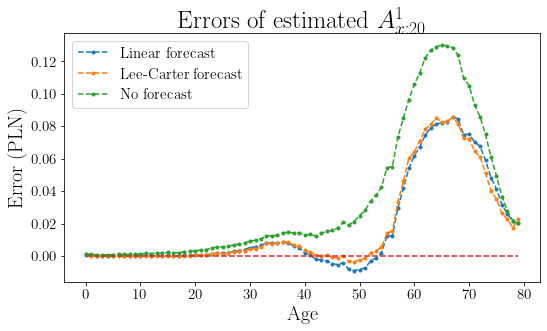

In [61]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.5 * Image_width))

ax.plot((A_linear-A_farseer), '.--', label = 'Linear forecast')
ax.plot((A_LC-A_farseer), '.--', label = 'Lee-Carter forecast')
ax.plot((straight_forward_A - A_farseer), '.--', label ='No forecast')
ax.plot(np.zeros(80), '--')
ax.set_xlabel("Age")
ax.set_ylabel("Error (PLN)")
ax.legend()
ax.set_title("Errors of estimated $A^1_{x:20}$")
fig.tight_layout()
plt.savefig('Figures\\TermInsuranceErrors.jpg', bbox_inches = 'tight', dpi = 700)

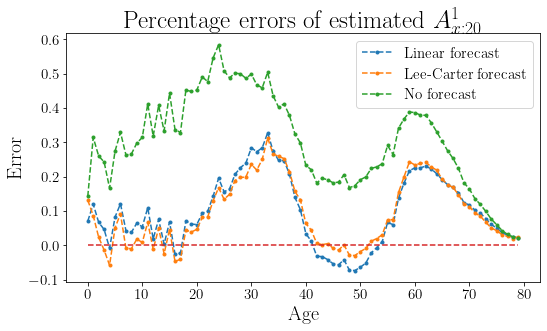

In [62]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.5 * Image_width))

ax.plot((A_linear-A_farseer)/A_farseer, '.--', label = 'Linear forecast')
ax.plot((A_LC-A_farseer)/A_farseer, '.--', label = 'Lee-Carter forecast')
ax.plot((straight_forward_A - A_farseer)/A_farseer, '.--', label ='No forecast')
ax.plot(np.zeros(80), '--')
ax.set_xlabel("Age")
ax.set_ylabel("Error")
ax.legend()
ax.set_title("Percentage errors of estimated $A^1_{x:20}$")
fig.tight_layout()
plt.savefig('Figures\\TermInsurancePercentageErrors.jpg', bbox_inches = 'tight', dpi = 700)

## Life annuity

$$ \overset{..}{a}_{x:n} = \sum_{k=0}^{n-1} v^{k} {}_k p^0_x$$

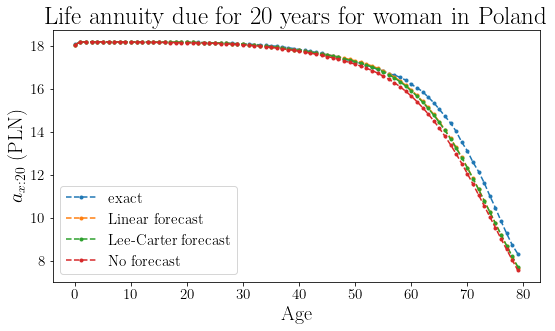

In [63]:
delta = 0.01
v = np.exp(-delta)
forecasting_horizon = np.arange(0, n)
forecasting_horizon = forecasting_horizon[None, :]

discounting_factor = v**forecasting_horizon


kPx, Qkx = linear
a_linear = discounting_factor*kPx
a_linear = a_linear.sum(1)

kPx, Qkx = LC
a_LC = discounting_factor*kPx
a_LC = a_LC.sum(1)

kPx, Qkx = farseer
a_farseer = discounting_factor*kPx
a_farseer = a_farseer.sum(1)


kPx, Qkx = no_prediction
a_no_prediction = discounting_factor*kPx
a_no_prediction = a_no_prediction.sum(1)


fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.5 * Image_width))

ax.plot(a_farseer, '.--', label="exact")
ax.plot(a_linear, '.--', label="Linear forecast")
ax.plot(a_LC, '.--', label="Lee-Carter forecast")
ax.plot(a_no_prediction, '.--', label = "No forecast")
ax.set_xlabel("Age")
ax.set_ylabel("$a_{x:20}$ (PLN)")
ax.legend()
ax.set_title("Life annuity due for 20 years for woman in Poland")
fig.tight_layout()
plt.savefig('Figures\\LifeAnnuity.jpg', bbox_inches = 'tight', dpi = 700)

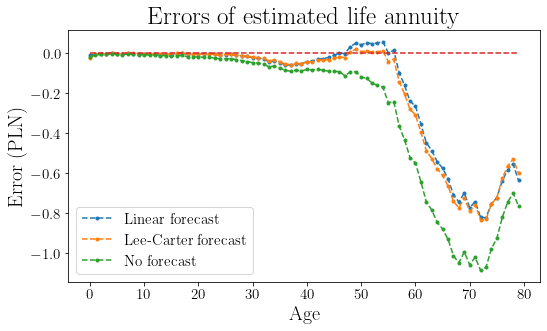

In [64]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.5 * Image_width))

ax.plot((a_linear-a_farseer), '.--', label = 'Linear forecast')
ax.plot((a_LC-a_farseer), '.--', label = 'Lee-Carter forecast')
ax.plot((a_no_prediction - a_farseer), '.--', label ='No forecast')
ax.plot(np.zeros(80), '--')
ax.set_xlabel("Age")
ax.set_ylabel("Error (PLN)")
ax.legend()
ax.set_title("Errors of estimated life annuity")
fig.tight_layout()
plt.savefig('Figures\\LifeAnnuityErrors.jpg', bbox_inches = 'tight', dpi = 700)

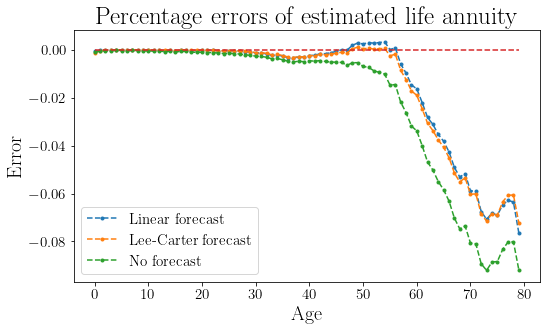

In [65]:
fig, ax = plt.subplots(figsize = (0.8 * Image_width, 0.5 * Image_width))

ax.plot((a_linear-a_farseer)/a_farseer, '.--', label = 'Linear forecast')
ax.plot((a_LC-a_farseer)/a_farseer, '.--', label = 'Lee-Carter forecast')
ax.plot((a_no_prediction - a_farseer)/a_farseer, '.--', label ='No forecast')
ax.plot(np.zeros(80), '--')
ax.set_xlabel("Age")
ax.set_ylabel("Error")
ax.legend()
ax.set_title("Percentage errors of estimated life annuity")
fig.tight_layout()
plt.savefig('Figures\\LifeAnnuityPercentageErrors.jpg', bbox_inches = 'tight', dpi = 700)